# Part 2 - LSTM

## Imports

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import json
import gensim
import re
import torch.optim as optim
from torchtext.vocab import GloVe, FastText
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load processed data

In [2]:
with open('../data_processed/LR_train_tagged.json') as f: 
    LR_train = json.load(f)
    
with open('../data_processed/LR_test_tagged.json') as f:
    LR_test = json.load(f)
    
with open('../data_processed/LR_val_tagged.json') as f:
    LR_val = json.load(f)

with open('../data_processed/NER_train_tagged.json') as f:
    NER_train = json.load(f)

with open('../data_processed/NER_test_tagged.json') as f:
    NER_test = json.load(f)

with open('../data_processed/NER_val_tagged.json') as f:
    NER_val = json.load(f)


## Load vector embedding models

### Word2Vec


In [3]:
w2vmodel = KeyedVectors.load_word2vec_format('../.vector_cache/GoogleNews-vectors-negative300.bin', binary=True)

### GloVe


In [4]:
# glovemodel = GloVe(name='6B', dim=300)
glove_file = '../.vector_cache/glove.6B.300d.txt'
glovemodel = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glovemodel[word] = vector


### Fasttext

In [5]:
# fasttextmodel = FastText()
fasttext_file = '../.vector_cache/wiki.en.vec'
fastmodel = {}
with open(fasttext_file, 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.array([x for x in values[1:] if x], dtype='float32')
        fastmodel[word] = vector

## Creating and Training the Models

### Create list of unique labels - NER

In [6]:
unique_labels = []
for entry in NER_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_NER = {}
unique_labels = list(set(unique_labels))
unique_labels = sorted(unique_labels)

for label_index in range(len(unique_labels)):
    label_dict_NER[unique_labels[label_index]] = label_index

# label_dict_NER['p0p'] = len(unique_labels)
# label_dict['UNK'] = len(unique_labels) + 1

output_dict = {}
for key, value in label_dict_NER.items():
    new_key = key.replace('B_', '').replace('I_', '')
    if new_key not in output_dict:
        output_dict[new_key] = len(output_dict)

label_dict_NER = output_dict
label_dict_NER

{'CASE_NUMBER': 0,
 'COURT': 1,
 'DATE': 2,
 'GPE': 3,
 'JUDGE': 4,
 'ORG': 5,
 'OTHER_PERSON': 6,
 'PETITIONER': 7,
 'PRECEDENT': 8,
 'PROVISION': 9,
 'RESPONDENT': 10,
 'STATUTE': 11,
 'WITNESS': 12,
 'O': 13}

### Create list of unique labels - LR

In [7]:
unique_labels = []
for entry in LR_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_LR = {}
unique_labels = list(set(unique_labels))
unique_labels = sorted(unique_labels)

for label_index in range(len(unique_labels)):
    label_dict_LR[unique_labels[label_index]] = label_index

# label_dict_LR['p0p'] = len(unique_labels)
# label_dict['UNK'] = len(unique_labels) + 1
label_dict_LR

{'B': 0, 'I': 1, 'O': 2}

### Verifying LR_train

In [8]:
# id = 0
# for entry in LR_train:
#     if (len(entry['text'].split()) != len(entry['labels'])):
#         print(entry['id'])
#         print(len(entry['text'].split()))
#         print(len(entry['labels']))

### Define NER dataset class

In [9]:
class NER_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        self.padding_word = "O"
        # self.padding_word = "p0p"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)
            
        self.data = dataset
        self.input = []
        self.labels = []
        
        for i in range(len(self.data)):
            lst = self.data[i]["labels"]
            for j in range(len(lst)):
                if lst[j].startswith("B_"):
                    lst[j] = lst[j][2:]
                elif lst[j].startswith("I_"):
                    lst[j] = lst[j][2:]
            self.data[i]["labels"] = lst

        if padding:
            for entry in self.data:
                padded_entry = entry["text"].split() + [self.padding_word] * (75 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (75 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in self.data:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_NER

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []
        
        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append(self.model[self.padding_word])
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Define LR Dataset class

In [10]:
class LR_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        self.padding_word = "O"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)

        self.data = dataset
        self.input = []
        self.labels = []
        if padding:
            for entry in dataset:
                padded_entry = entry["text"].split() + [self.padding_word] * (78 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (78 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in dataset:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_LR

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []

        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append(self.model[self.padding_word])
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Training Loop

In [11]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    train_accuracy_scores = []
    val_accuracy_scores = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        all_val_labels = []
        all_val_preds = []

        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            outputs, hn = model(inputs)
            outputs = outputs.reshape(-1, outputs.shape[-1])
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
        train_accuracy_scores.append(train_accuracy)
        train_f1_scores.append(train_f1)

        model.eval()
        with torch.no_grad():

            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs, hn = model(inputs)
                outputs = outputs.reshape(-1, outputs.shape[-1])
                labels = labels.reshape(-1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

            val_accuracy = accuracy_score(all_val_labels, all_val_preds)
            val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
            val_accuracy_scores.append(val_accuracy)
            val_f1_scores.append(val_f1)

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch {epoch + 1}\n"
              f"Train loss: {train_losses[-1]}, Val loss: {val_losses[-1]}\n"
              f"Train accuracy: {train_accuracy}, Val accuracy: {val_accuracy}\n"
              f"Train F1: {train_f1}, Val F1: {val_f1}")
        print("=====================================================================================================")

    return model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores
        

### Modified NN models

In [12]:
class SequentialModel(nn.Module):
    def __init__(self, label_dict, base_model):
        super().__init__()
        self.sequential_model = base_model
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, len(label_dict))
        self.relu = nn.ReLU()

    def forward(self, x):
        x, hn = self.sequential_model(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x, hn

## Word2Vec Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [13]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "word2vec", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "word2vec", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "word2vec", padding=True), batch_size=64, shuffle=True)

c:\Users\Jaskaran\miniconda3\envs\mlenv\lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [14]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "word2vec", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "word2vec", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "word2vec", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [15]:
model = SequentialModel(label_dict_NER, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [16]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t1_lstm_word2vec.pt")

C:\Users\Jaskaran\AppData\Local\Temp\ipykernel_20804\4087966327.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(word_vecs), torch.tensor(labels)


Epoch 1
Train loss: 0.4635759800979772, Val loss: 0.3038948274710599
Train accuracy: 0.9005129866623468, Val accuracy: 0.9152319508448541
Train F1: 0.07671851056571695, Val F1: 0.09767650332405034
Epoch 2
Train loss: 0.21871766494107, Val loss: 0.15875529585515752
Train accuracy: 0.9365970084777796, Val accuracy: 0.9534254992319509
Train F1: 0.3143158910969092, Val F1: 0.4691103947198285
Epoch 3
Train loss: 0.140057658488603, Val loss: 0.12883696485968196
Train accuracy: 0.957239591770614, Val accuracy: 0.960516129032258
Train F1: 0.5057286715771919, Val F1: 0.513628878480847


In [17]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9591840277777778 Test F1: 0.5060909584693121


### Plots

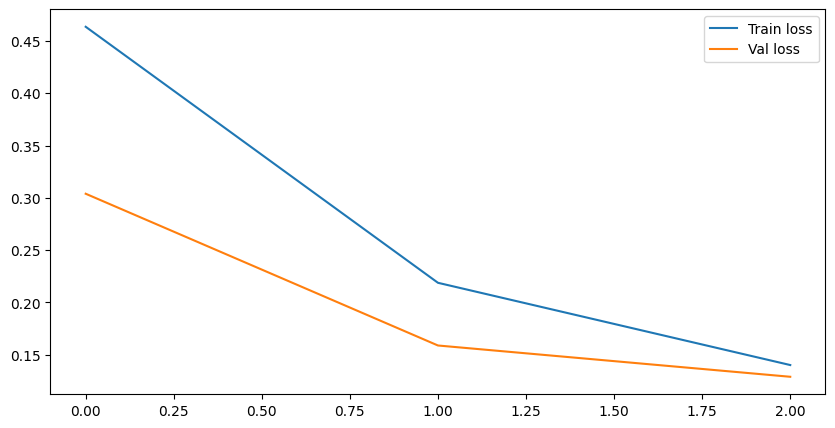

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

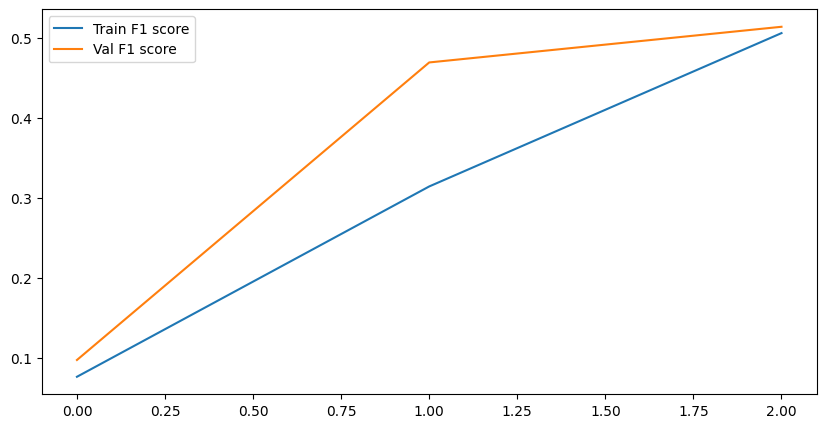

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

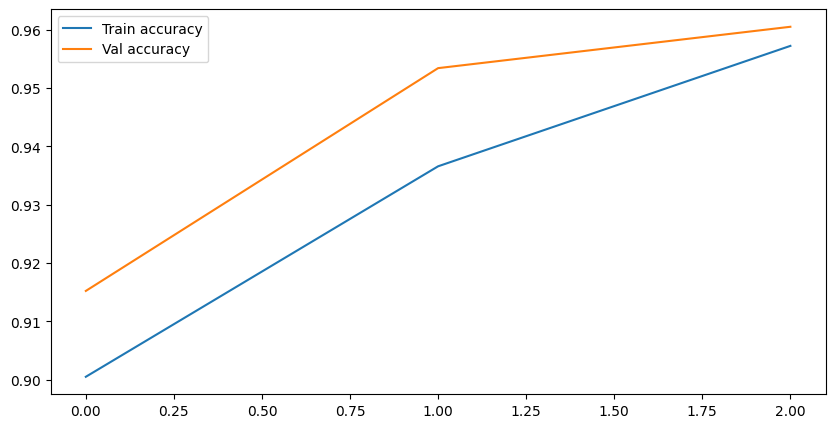

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training and Testing

In [21]:
model = SequentialModel(label_dict_LR, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [22]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t2_lstm_word2vec.pt")

Epoch 1
Train loss: 0.23963127533594766, Val loss: 0.1337626780072848
Train accuracy: 0.9736089885096507, Val accuracy: 0.9736089885096507
Train F1: 0.328876014846575, Val F1: 0.328876014846575
Epoch 2
Train loss: 0.11380208681027094, Val loss: 0.09188064734141031
Train accuracy: 0.9736089885096507, Val accuracy: 0.9736089885096507
Train F1: 0.328876014846575, Val F1: 0.328876014846575
Epoch 3
Train loss: 0.08333317463596662, Val loss: 0.07649433960517248
Train accuracy: 0.9736089885096507, Val accuracy: 0.9739061527140997
Train F1: 0.328876014846575, Val F1: 0.33967822898715


In [23]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9739061527140997 Test F1: 0.33967822898715


### Plots

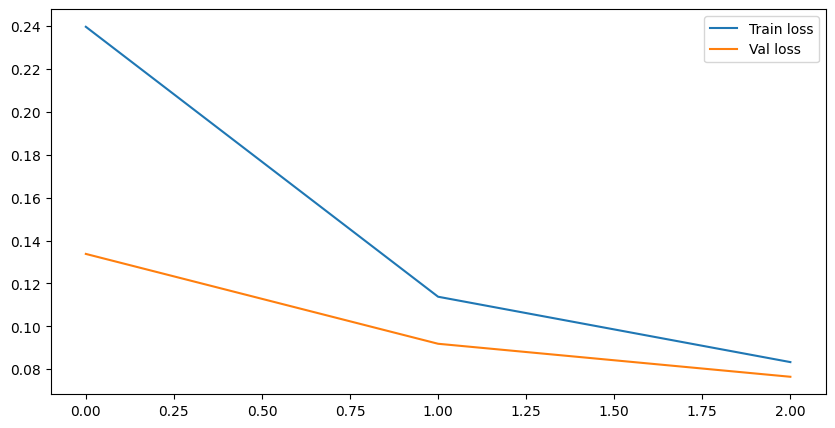

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

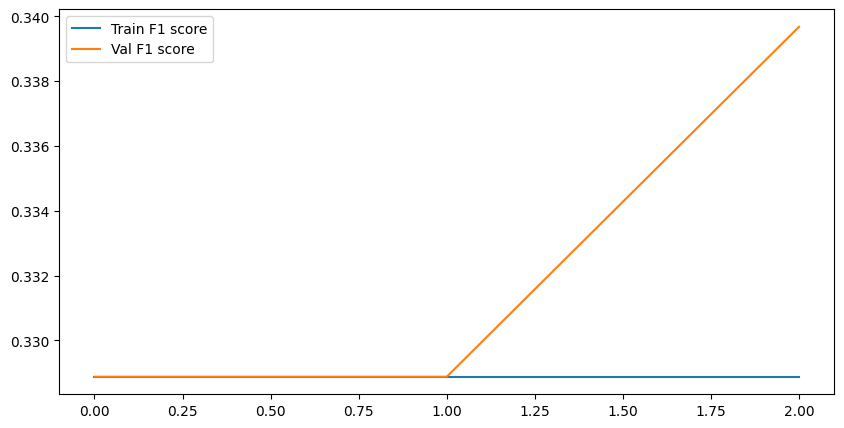

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

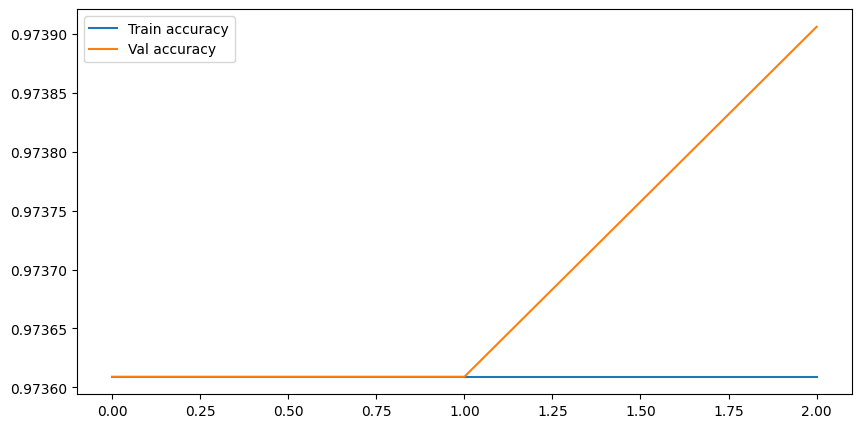

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

## GloVe Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [27]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "glove", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "glove", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "glove", padding=True), batch_size=64, shuffle=True)

### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [28]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "glove", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "glove", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "glove", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [29]:
model = SequentialModel(label_dict_NER, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [30]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t1_lstm_glove.pt")

Epoch 1
Train loss: 0.42223018899406356, Val loss: 0.278181849157109
Train accuracy: 0.9054376586208759, Val accuracy: 0.9247803379416283
Train F1: 0.11562952659452556, Val F1: 0.19763652635064097
Epoch 2
Train loss: 0.24674841823037139, Val loss: 0.22532078974387226
Train accuracy: 0.9319660888816891, Val accuracy: 0.9366513056835637
Train F1: 0.2661411210894713, Val F1: 0.2877150866768329
Epoch 3
Train loss: 0.20942767594278472, Val loss: 0.21198522431008957
Train accuracy: 0.9393682164263729, Val accuracy: 0.9376958525345622
Train F1: 0.33345504103537615, Val F1: 0.3322257047126306


In [31]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9354340277777777 Test F1: 0.33124526569777524


### Plots

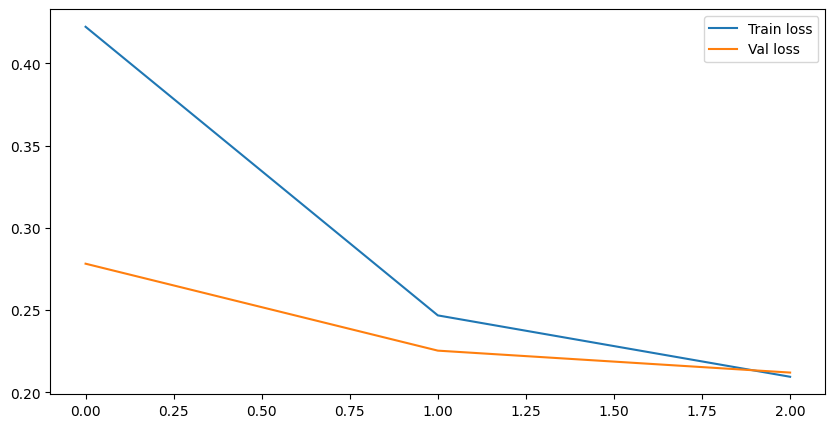

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

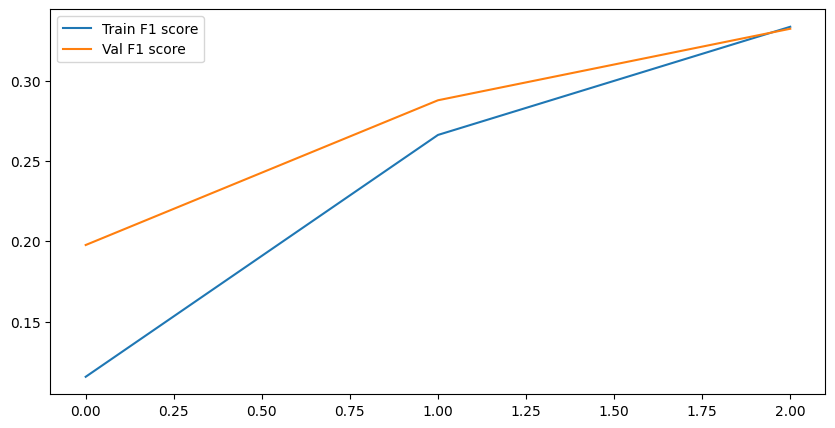

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

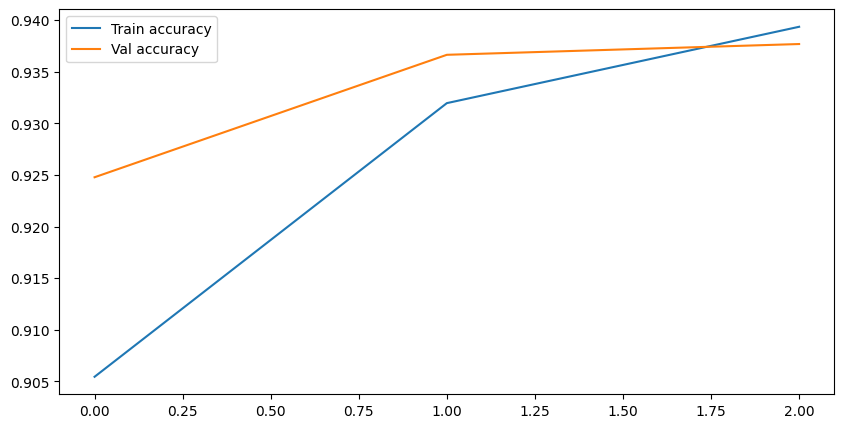

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training

In [35]:
model = SequentialModel(label_dict_LR, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [36]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t2_lstm_glove.pt")

Epoch 1
Train loss: 0.24463003973166147, Val loss: 0.091683595875899
Train accuracy: 0.90606781004132, Val accuracy: 0.9736372898624555
Train F1: 0.33593062577212146, Val F1: 0.3304370873446793
Epoch 2
Train loss: 0.08137400398651759, Val loss: 0.07594545086224874
Train accuracy: 0.9736231391860531, Val accuracy: 0.9736372898624555
Train F1: 0.3304334550692381, Val F1: 0.33095260532968923
Epoch 3
Train loss: 0.07024165987968445, Val loss: 0.058782204240560534
Train accuracy: 0.9763117677024962, Val accuracy: 0.9797928340974699
Train F1: 0.5037466446872613, Val F1: 0.6738689355018753


In [37]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9797928340974699 Test F1: 0.6738689355018753


### Plots

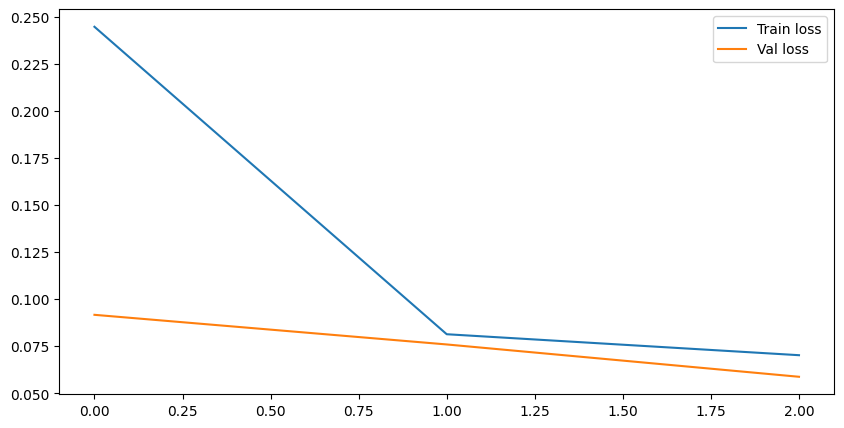

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

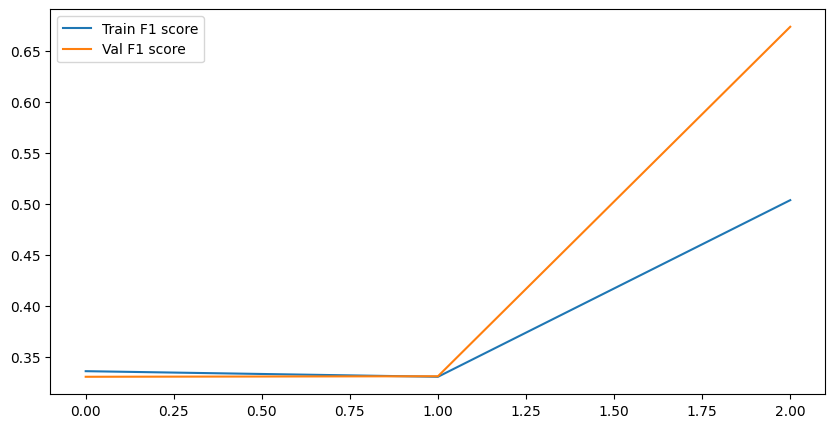

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

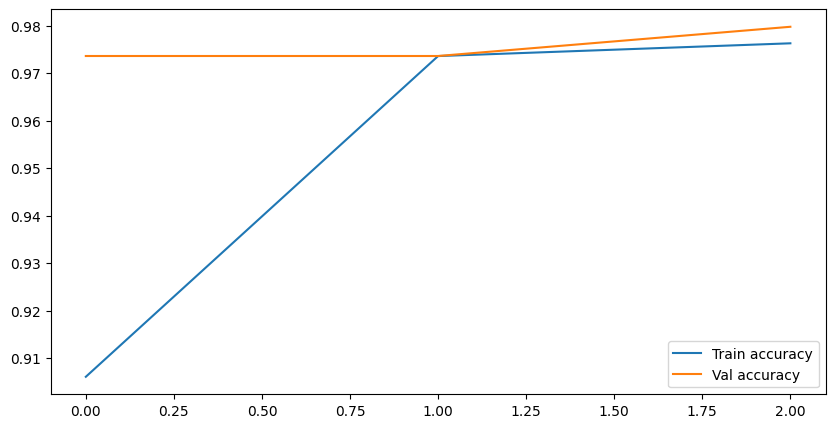

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

## Fasttext Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [41]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "fasttext", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "fasttext", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "fasttext", padding=True), batch_size=64, shuffle=True)

### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [42]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "fasttext", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "fasttext", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "fasttext", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [43]:
model = SequentialModel(label_dict_NER, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [44]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t1_lstm_fasttext.pt")

Epoch 1
Train loss: 0.5276932384549957, Val loss: 0.37027814458398256
Train accuracy: 0.8996900480587505, Val accuracy: 0.9082642089093702
Train F1: 0.06837464542317427, Val F1: 0.07847718572125074
Epoch 2
Train loss: 0.34786306244810833, Val loss: 0.30977046840331135
Train accuracy: 0.9158723473189697, Val accuracy: 0.9179109062980031
Train F1: 0.10459910809945241, Val F1: 0.11360708652228436
Epoch 3
Train loss: 0.2813254550252993, Val loss: 0.26575277044492607
Train accuracy: 0.9239505372860306, Val accuracy: 0.9267096774193548
Train F1: 0.17943094379918925, Val F1: 0.23022079178353966


In [45]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9244097222222222 Test F1: 0.24225176273019042


### Plots

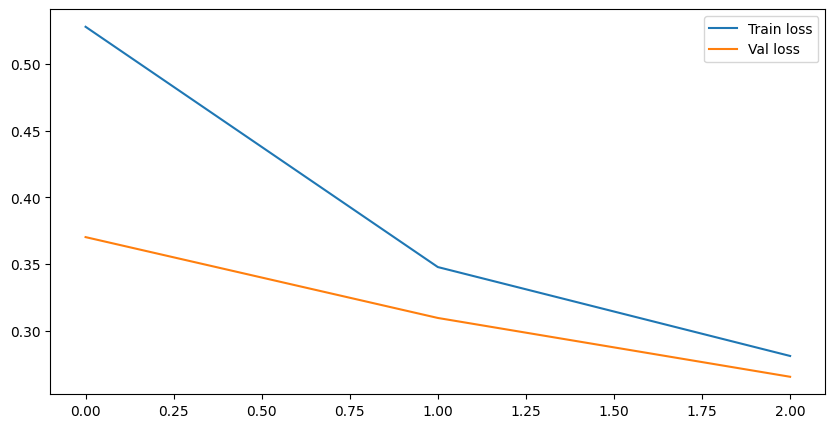

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

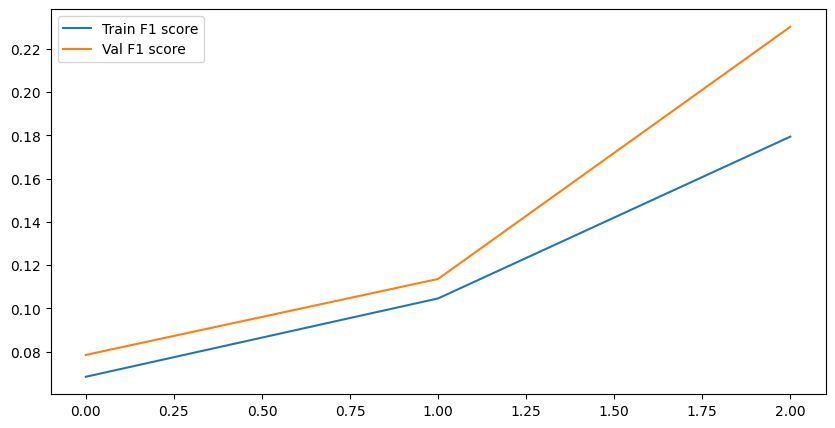

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

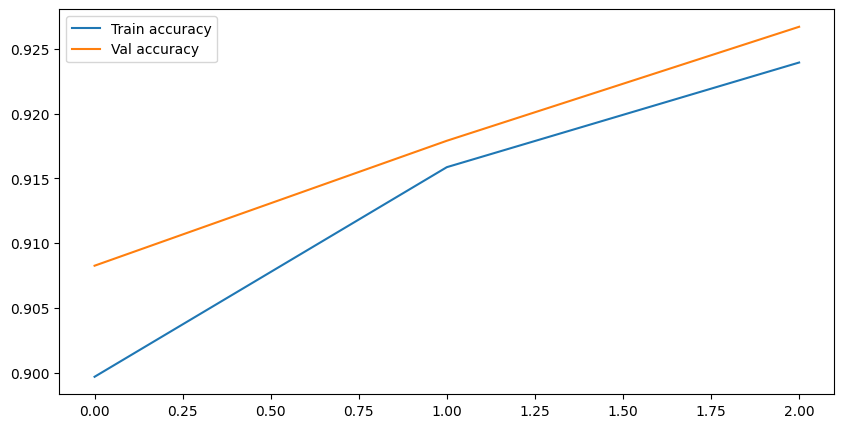

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training and Testing

In [49]:
model = SequentialModel(label_dict_LR, torch.nn.LSTM(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [50]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t2_lstm_fasttext.pt")

Epoch 1
Train loss: 0.24775349448124567, Val loss: 0.10284840166568757
Train accuracy: 0.9057847965132734, Val accuracy: 0.9736089885096507
Train F1: 0.32328273470890045, Val F1: 0.328876014846575
Epoch 2
Train loss: 0.08796005720893542, Val loss: 0.07750944842894872
Train accuracy: 0.9740193581253184, Val accuracy: 0.9755759325295749
Train F1: 0.35869299719833436, Val F1: 0.44036486240046185
Epoch 3
Train loss: 0.07196117440859477, Val loss: 0.06049248700340589
Train accuracy: 0.9770617535518198, Val accuracy: 0.9794956698930208
Train F1: 0.48760550883970644, Val F1: 0.5583649832354007


In [51]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9794956698930208 Test F1: 0.5583649832354007


### Plots

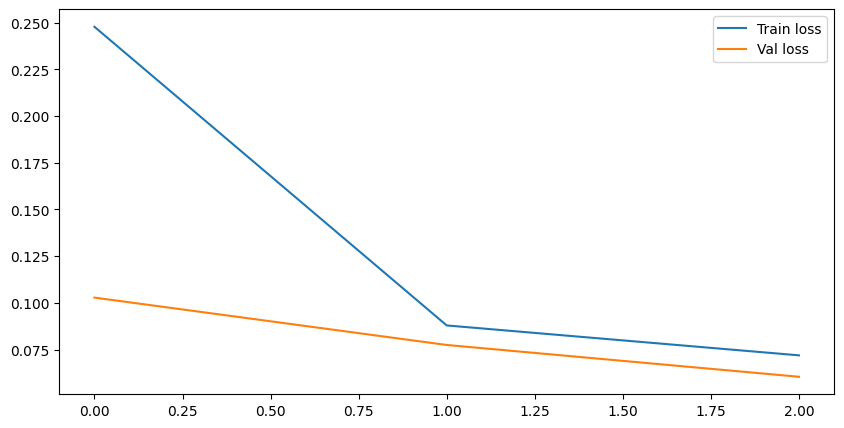

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

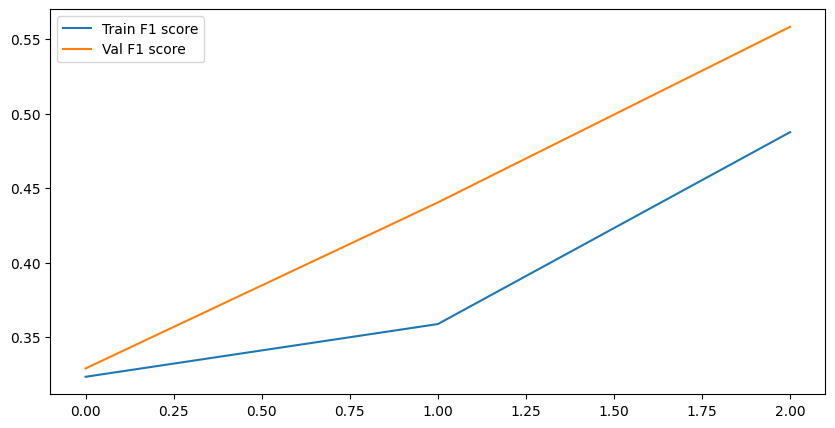

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

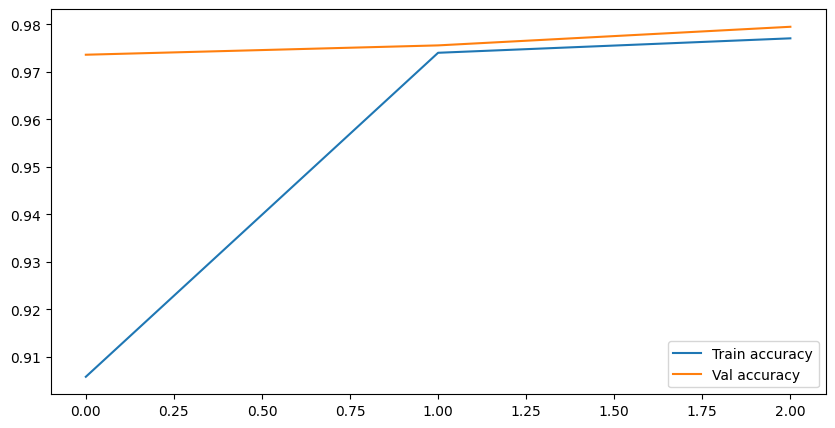

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()